In [252]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from dateutil.relativedelta import relativedelta
from sklearn import linear_model, metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
from sklearn.cluster import KMeans

import warnings
warnings.simplefilter("ignore", UserWarning)

In [60]:
data = pd.read_csv('assignment.csv')
data = data.sort_values(by=['timestamp'], ascending=False)
data['date'] = data['timestamp'].astype('datetime64[D]')

In [10]:
groupdata = data.groupby('user_id').agg({'purchase_value':'sum', 'timestamp':'count'}).reset_index()
groupdata = groupdata.rename(columns={'timestamp':'count'})
groupdata = groupdata.sort_values(by=['count'], ascending=False)

## Defining Churn

##### Since we don't have a variable named "churn", we have to define it based on the data

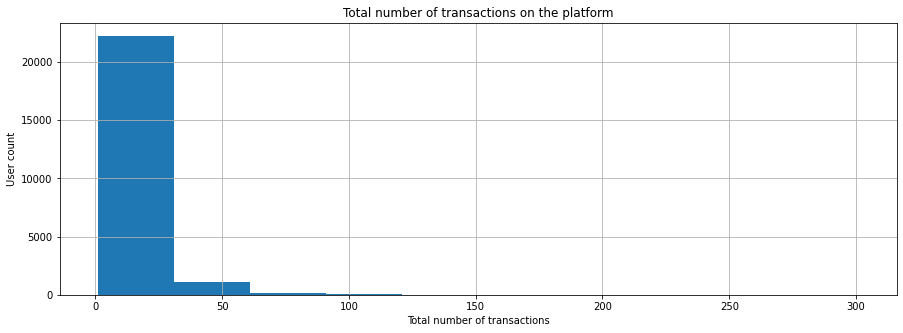

In [269]:
groupdata[['count']].hist(figsize=(15,5))
plt.title('Total number of transactions on the platform')
plt.xlabel('Total number of transactions')
plt.ylabel('User count')
plt.show()

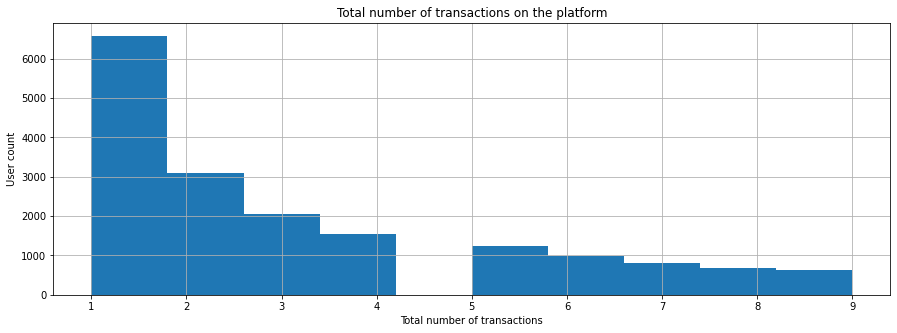

In [268]:
_groupdata = groupdata[groupdata['count']<10]
_groupdata[['count']].hist(figsize=(15,5))
plt.title('Total number of transactions on the platform')
plt.xlabel('Total number of transactions')
plt.ylabel('User count')
plt.show()

In [25]:
from scipy import stats as st

print(st.mode(groupdata[['count']]))

# mode is 1 which implies that majority of user just do one transaction on the platform

ModeResult(mode=array([[1]]), count=array([[6579]]))


### mode is 1 which implies that majority of user just do one transaction on the platform

In [64]:
data['diff'] = 0
for user in tqdm(data['user_id'].unique()):
    temp = data[data['user_id']==user]
    if temp.shape[0]>1:
        data.loc[data['user_id']==user, 'diff'] = (temp['date'] - temp['date'].shift(-1)).dt.days
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23583/23583 [07:59<00:00, 49.20it/s]


In [78]:
# data.to_csv('checkpoit.csv')
inactivation_days = {}

temp = data[data['diff']>1]
for i in tqdm(temp['diff'].unique()):
    inactivation_days[int(i-1)] = temp[temp['diff']==i].shape[0]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:00<00:00, 2849.11it/s]


In [79]:
inactivation_days

{6: 6016,
 1: 25284,
 8: 3611,
 2: 17418,
 3: 12406,
 4: 9057,
 19: 1037,
 17: 1215,
 13: 2012,
 57: 86,
 5: 7265,
 10: 2621,
 20: 1057,
 9: 2970,
 23: 667,
 40: 194,
 35: 276,
 7: 4627,
 24: 667,
 11: 2304,
 16: 1335,
 12: 2034,
 27: 562,
 45: 126,
 21: 899,
 54: 103,
 25: 587,
 107: 3,
 14: 1691,
 41: 222,
 47: 132,
 29: 414,
 38: 234,
 80: 23,
 106: 5,
 28: 471,
 77: 32,
 48: 153,
 15: 1542,
 32: 337,
 90: 14,
 22: 715,
 31: 357,
 18: 1081,
 34: 318,
 55: 98,
 37: 244,
 26: 555,
 119: 1,
 52: 92,
 44: 160,
 94: 18,
 30: 410,
 51: 111,
 61: 62,
 85: 12,
 59: 70,
 58: 62,
 71: 48,
 64: 49,
 33: 337,
 93: 8,
 42: 173,
 62: 67,
 36: 252,
 53: 87,
 46: 153,
 68: 57,
 113: 2,
 87: 17,
 69: 54,
 50: 107,
 78: 30,
 91: 17,
 89: 16,
 66: 41,
 114: 1,
 100: 9,
 74: 28,
 75: 41,
 43: 172,
 63: 64,
 73: 31,
 84: 24,
 82: 22,
 65: 47,
 117: 2,
 67: 33,
 110: 4,
 49: 124,
 81: 19,
 56: 101,
 95: 11,
 105: 2,
 39: 191,
 79: 25,
 101: 9,
 99: 5,
 72: 37,
 86: 14,
 112: 2,
 60: 72,
 76: 36,
 109: 6,

In [82]:
days = list(inactivation_days.keys())
counts = list(inactivation_days.values())

In [88]:
dt = pd.DataFrame()
dt['inactive_days'] = days
dt['cases'] = counts

dt = dt.sort_values(by=['inactive_days'])
dt = dt[dt['inactive_days']<50]

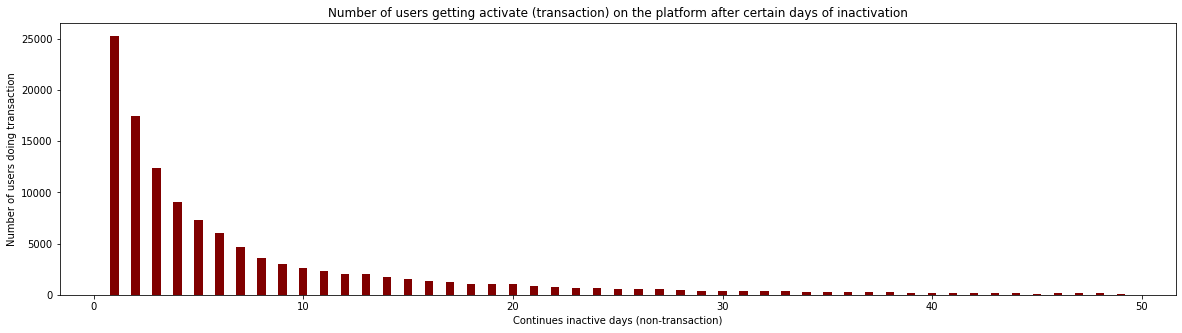

In [91]:
fig = plt.figure(figsize = (20, 5))

plt.bar(dt['inactive_days'], dt['cases'], color ='maroon',
        width = 0.4)
 
plt.xlabel("Continues inactive days (non-transaction)")
plt.ylabel("Number of users doing transaction")
plt.title("Number of users getting activate (transaction) on the platform after certain days of inactivation")
plt.show()

In [97]:
total_transaction = dt['cases'].sum()
dt['cumulative_freq'] = dt['cases'].cumsum()
dt['cumulative_freq'] = dt['cumulative_freq']/total_transaction

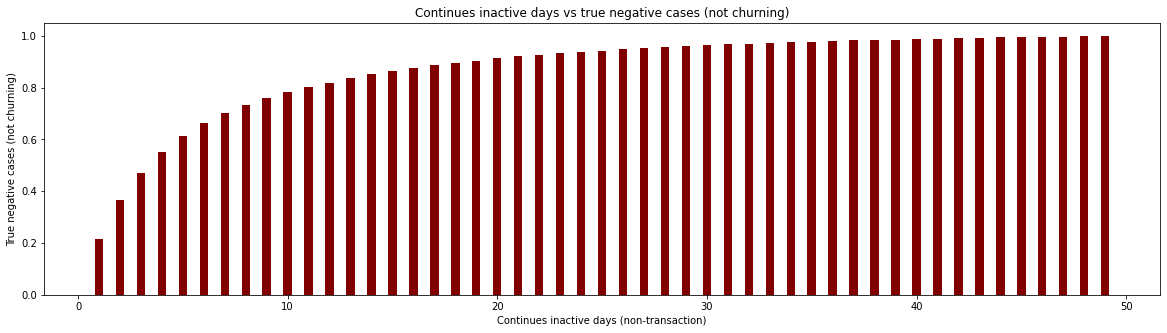

In [101]:
fig = plt.figure(figsize = (20, 5))

plt.bar(dt['inactive_days'], dt['cumulative_freq'], color ='maroon',
        width = 0.4)
 
plt.xlabel("Continues inactive days (non-transaction)")
plt.ylabel("True negative cases (not churning)")
plt.title("Continues inactive days vs true negative cases (not churning)")
plt.show()

### If we choose 30 days of continuous inactivation as a definition of churn, then we can cover >96% of true negative cases and there are only <4% chances of false negative cases

### according to the above analysis:
    - if user is inactive on the platform for more than 30 days = churn
    - else user is = not churn

## Data Preparation

In [110]:
data['date'].max()

Timestamp('2022-12-14 00:00:00')

In [142]:
dt = data.groupby('user_id').agg({'date':'max'}).reset_index()

dt['recency'] = (datetime.datetime(2022, 12, 14) - dt['date']).dt.days

dt['churn'] = 0
dt.loc[dt['recency']<=30, 'churn'] = 0
dt.loc[dt['recency']>30, 'churn'] = 1

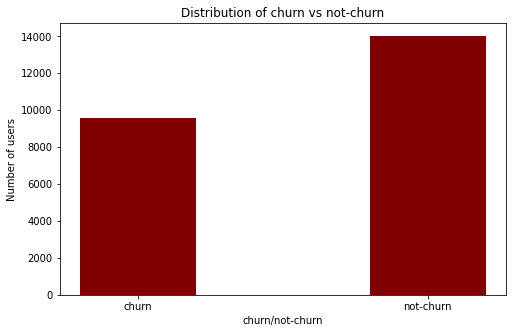

In [143]:
fig = plt.figure(figsize = (8, 5))

plt.bar(['churn', 'not-churn'], [9561, 14022], color ='maroon',
        width = 0.4)
 
plt.xlabel("churn/not-churn")
plt.ylabel("Number of users")
plt.title("Distribution of churn vs not-churn")
plt.show()

In [175]:
last_week = datetime.datetime(2022, 12, 14) - relativedelta(days=7)
last_week_2nd = last_week - relativedelta(days=7)
last_week_3rd = last_to_last_week - relativedelta(days=7)

def get_features_timebasis(data, dt, time, string):
    temp = data[data['date'] >= time]
    temp = temp.groupby('user_id').agg({'purchase_value':'sum', 'date':'count'}).reset_index()
    temp = temp.rename(columns={'date':'count_{}'.format(string), 'purchase_value':'purchase_value_{}'.format(string)})

    dt = dt.merge(temp, on=['user_id'], how='left')
    
    return dt


for item in [[last_week, 'last_week'], [last_week_2nd, 'last_week_2nd'], [last_week_3rd, 'last_week_3rd']]:
    dt = get_features_timebasis(data, dt, item[0], item[1])

In [185]:
dt = dt.replace(np.nan, 0)
dt.head()

,user_id,date,recency,churn,purchase_value_last_week,count_last_week,purchase_value_last_week_2nd,count_last_week_2nd,purchase_value_last_week_3rd,count_last_week_3rd
0,0000602f168960c53835096f2daad506a80fcef2b4b13a...,2022-11-18,26,0,0.0,0.0,0.0,0.0,0.0,0.0
1,0001b82c569a333a80c48f2004827e4a8e5be5840fbd9b...,2022-09-14,91,1,0.0,0.0,0.0,0.0,0.0,0.0
2,000700164cee77c05439c206a588b66fe734150ede585f...,2022-12-13,1,0,362.0,3.0,362.0,3.0,544.0,4.0
3,000a4c3acfbf3baf967560f71cd0d1dd87957cfd7c027f...,2022-11-19,25,0,0.0,0.0,0.0,0.0,0.0,0.0
4,001481e9e6ea150295c6e7664c9eb824dc2393ede3a88d...,2022-12-06,8,0,0.0,0.0,155.0,1.0,155.0,1.0


In [196]:
X = dt[['recency',  'purchase_value_last_week', 'count_last_week', 'purchase_value_last_week_2nd', 'count_last_week_2nd', 
        'purchase_value_last_week_3rd', 'count_last_week_3rd']]
y = dt[['churn']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=0)

In [187]:
std_slc = StandardScaler()
logistic_Reg = linear_model.LogisticRegression()

In [197]:
pipe = Pipeline(steps=[('std_slc', std_slc),
                        ('logistic_Reg', logistic_Reg)])

C = np.logspace(-4, 4, 50)
penalty = ['none', 'l2']
parameters = dict(logistic_Reg__C=C,
                  logistic_Reg__penalty=penalty)

clf_GS = GridSearchCV(pipe, parameters)


clf_GS.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('std_slc', StandardScaler()),
                                       ('logistic_Reg', LogisticRegression())]),
             param_grid={'logistic_Reg__C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137...
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                         'logistic_Reg__penalty': ['none', 'l2']})

In [198]:
print('Best Penalty:', clf_GS.best_estimator_.get_params()['logistic_Reg__penalty'])
print('Best C:', clf_GS.best_estimator_.get_params()['logistic_Reg__C'])
print(); print(clf_GS.best_estimator_.get_params()['logistic_Reg'])

Best Penalty: none
Best C: 0.0001

LogisticRegression(C=0.0001, penalty='none')


In [201]:
# confusion matrix
y_predicted = clf_GS.predict(X_test)
metrics.confusion_matrix(y_test, y_predicted)

array([[10515,     5],
       [    0,  7168]])

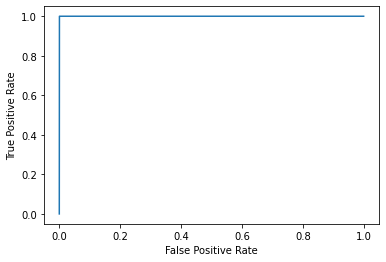

In [203]:
y_pred_proba = clf_GS.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [207]:
print('precision: ', round(precision_score(y_test, y_predicted), 3))
print('recall: ', round(recall_score(y_test, y_predicted), 3))

precision:  0.999
recall:  1.0


## Customer Segmentation
    Using RFM - (Recency | Frequency | Monetary) framwork

In [234]:
# Customer segmentation - RFM
temp = data.groupby('user_id').agg({'date': 'count', 'purchase_value':'sum'}).reset_index()
temp = temp.rename(columns={'date':'frequency', 'purchase_value':'monetary'})
dt = dt.merge(temp, on=['user_id'], how='left')

dt.head()

,user_id,date,recency,churn,purchase_value_last_week,count_last_week,purchase_value_last_week_2nd,count_last_week_2nd,purchase_value_last_week_3rd,count_last_week_3rd,frequency,monetary
0,0000602f168960c53835096f2daad506a80fcef2b4b13a...,2022-11-18,26,0,0.0,0.0,0.0,0.0,0.0,0.0,1,132.0
1,0001b82c569a333a80c48f2004827e4a8e5be5840fbd9b...,2022-09-14,91,1,0.0,0.0,0.0,0.0,0.0,0.0,1,113.0
2,000700164cee77c05439c206a588b66fe734150ede585f...,2022-12-13,1,0,362.0,3.0,362.0,3.0,544.0,4.0,24,4727.0
3,000a4c3acfbf3baf967560f71cd0d1dd87957cfd7c027f...,2022-11-19,25,0,0.0,0.0,0.0,0.0,0.0,0.0,1,139.0
4,001481e9e6ea150295c6e7664c9eb824dc2393ede3a88d...,2022-12-06,8,0,0.0,0.0,155.0,1.0,155.0,1.0,2,482.0


Text(0, 0.5, 'WCSS')

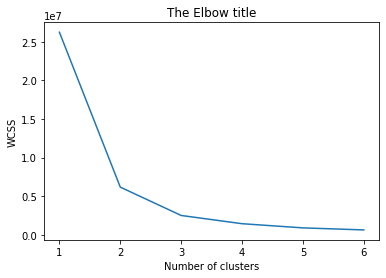

In [237]:
wcss=[]
for i in range(1,7):
    kmeans = KMeans(i)
    kmeans.fit(dt[['recency']])
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

number_clusters = range(1,7)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

Text(0, 0.5, 'WCSS')

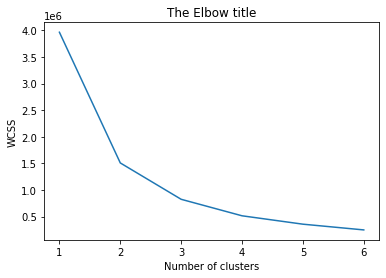

In [238]:
wcss=[]
for i in range(1,7):
    kmeans = KMeans(i)
    kmeans.fit(dt[['frequency']])
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

number_clusters = range(1,7)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

Text(0, 0.5, 'WCSS')

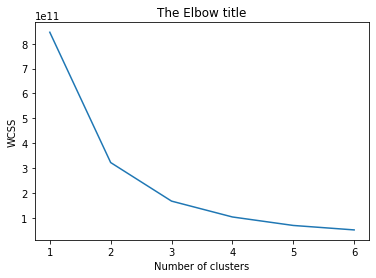

In [239]:
wcss=[]
for i in range(1,7):
    kmeans = KMeans(i)
    kmeans.fit(dt[['monetary']])
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

number_clusters = range(1,7)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [246]:
def clustering(clusters, feat):
    kmeans = KMeans(clusters)
    kmeans.fit(dt[[feat]])
    new_feat = '{}_cluster'.format(feat)
    dt[new_feat] = kmeans.predict(dt[[feat]])
    
    return dt

for item in [['recency', 5], ['frequency', 5], ['monetary', 5]]:
    dt = clustering(item[1], item[0])

In [248]:
dt['recency_cluster'] = dt['recency_cluster'] + 1
dt['frequency_cluster'] = dt['frequency_cluster'] + 1
dt['monetary_cluster'] = dt['monetary_cluster'] + 1

dt['rfm_rating'] = (dt['recency_cluster']+dt['frequency_cluster']+dt['monetary_cluster'])/3
dt['rfm_rating'] = dt['rfm_rating'].round(2)

In [251]:
# Each customer is given rating on the basis of their rfm value, higher rating -> better customer

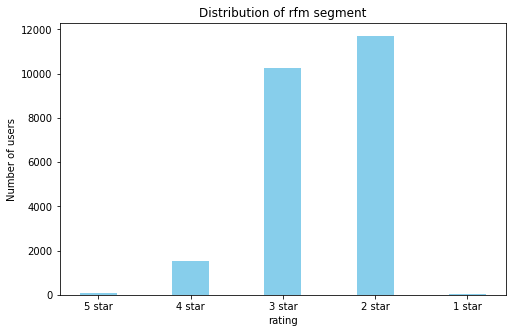

In [258]:
star_5 = dt[dt['rfm_rating'] > 4].shape[0]
star_4 = dt[(dt['rfm_rating'] > 3) & (dt['rfm_rating'] <= 4)].shape[0]
star_3 = dt[(dt['rfm_rating'] > 2) & (dt['rfm_rating'] <= 3)].shape[0]
star_2 = dt[(dt['rfm_rating'] > 1) & (dt['rfm_rating'] <= 2)].shape[0]
star_1 = dt[dt['rfm_rating'] <= 1].shape[0]

fig = plt.figure(figsize = (8, 5))

plt.bar(['5 star', '4 star', '3 star', '2 star', '1 star'], [star_5, star_4, star_3, star_2, star_1], color ='skyblue',
        width = 0.4)
 
plt.xlabel("rating")
plt.ylabel("Number of users")
plt.title("Distribution of rfm segment")
plt.show()

### Determine the customer lifetime value of the top users assuming they haven’t made any prior purchases

In [262]:
dt[dt['rfm_rating']>=4]['monetary'].mean()

26241.553719008265